In [ ]:
!pip install psycopg2-binary pandas numpy scikit-learn matplotlib

In [4]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt 

import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler


SCHEMA = {
    "wb_hnp": [
        "hdi",
        "gni",
        "life_satis",
    ],
    "country": ["life_expectancy", "crude_birth_rate", "crude_death_rate", "name"],
    "health": [
        "domestic_health_expenditure",
        "immunization_hepb",
        "immunization_measles",
        "stillbirth_rate",
        "mort_infant",
        "mort_non_communicable_disease",
        "mort_traffic_injury"
    ],
    "qualityoflife": [
        "unemployment_rate",
        "suicide_rate",
        "sanitation_access",
        "drinking_water_access",
    ],
    "nutrition": [
        "hyperten",
        "undernour",
    ],
    "population": ["p_growth_urban", "p_growth_rural"],
    "month": ["year"]
}


In [5]:
conn = psycopg2.connect("host=wb-hnp.postgres.database.azure.com user=bigboss dbname=postgres  password=@!p2T+u:x{cB")


cursor = conn.cursor()
query = f"SELECT DISTINCT {','.join([table + '.' + attribute for table, attributes in SCHEMA.items() for attribute in attributes])} FROM {','.join([table for table in SCHEMA.keys()])} WHERE {' AND '.join([f'wb_hnp.{table}_key = {table}.{table}_key' for table in SCHEMA.keys() if table != 'wb_hnp'])} "

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(
    list(map(list, data)),
    columns=[
        attribute for _, attributes in SCHEMA.items() for attribute in attributes
    ],
)



Text(0.5, 1.0, 'Histogram of Life Satisfaction')

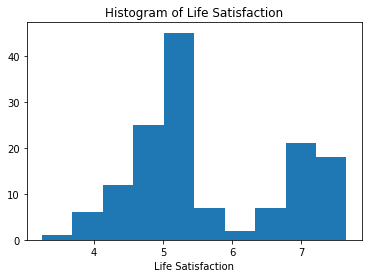

In [6]:
plt.hist(df.life_satis)
plt.xlabel("Life Satisfaction")
plt.title("Histogram of Life Satisfaction")

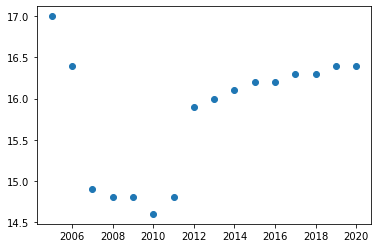

In [7]:
lebanon_sucks = df[df.name.eq("Lebanon")][["mort_traffic_injury", "year"]]
plt.scatter(lebanon_sucks.year, lebanon_sucks.mort_traffic_injury)

In [8]:
hdi_dict = {"very high":[0.779,0.782,0.78,0.79,0.795,0.799,0.804,0.804,0.813,0.818,0.823,0.827,0.832,0.837,0.841,0.846,0.851,0.855,0.86,0.861,0.866,0.871,0.874,0.878,0.882,0.886,0.888,0.89,0.892,0.898],
"high": [0.568,0.573,0.578,0.584,0.588,0.596,0.604,0.61,0.616,0.622,0.63,0.636,0.643,0.65,0.657,0.665,0.675,0.684,0.692,0.698,0.706,0.713,0.72,0.727,0.733,0.738,0.743,0.746,0.75,0.753],
"medium":[0.437,0.439,0.445,0.451,0.457,0.464,0.471,0.476,0.484,0.491,0.497,0.502,0.508,0.518,0.527,0.536,0.544,0.553,0.56,0.567,0.575,0.584,0.593,0.599,0.608,0.616,0.625,0.63,0.634,0.631],
"low": [0.352,0.353,0.355,0.356,0.356,0.361,0.368,0.373,0.379,0.384,0.386,0.393,0.402,0.417,0.426,0.435,0.444,0.452,0.461,0.469,0.473,0.479,0.484,0.49,0.496,0.499,0.501,0.505,0.507,0.513]}
hdi_dict = {key: value[15:] for key,value in hdi_dict.items()}

In [9]:
y_data_plus_year = df[["hdi", "year"]]

In [10]:
y = []
for  index, row in y_data_plus_year.iterrows():
    hdi = row.hdi
    year = row.year
    label = "very high"
    for name, arr in hdi_dict.items():
        if year != 2020:
            val = arr[int(year)-2005]
        else:
            val = arr[-1]
        if hdi >= val:
            label = name
            break
    y.append(label)

## Normalization

In [12]:
X_unnormalized = df.loc[:, ~df.columns.isin(["name", "year", "hdi"])]

In [13]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X_unnormalized)

In [15]:
labels_to_num = {"very high": 2,"high": 1, "medium": 0}
Y = np.asarray([labels_to_num[i] for i in y])

## Feature Selection

In [39]:
selector = RFE(DecisionTreeClassifier(random_state=420, ccp_alpha=0.04), n_features_to_select=5, step=1)
X_new = selector.fit_transform(X, Y)
X_unnormalized.columns[selector.support_]

Index(['stillbirth_rate', 'unemployment_rate', 'sanitation_access',
       'p_growth_urban', 'p_growth_rural'],
      dtype='object')

## Splitting Data

In [40]:

X_train, X_test, y_train, y_test = train_test_split(X_new, np.asarray(Y), test_size=0.33, random_state=42, stratify=Y)

<BarContainer object of 3 artists>

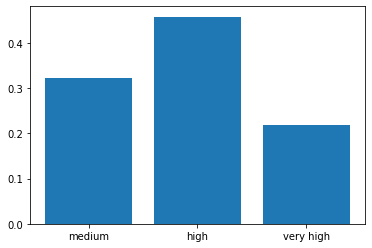

In [41]:
avgs_1 = []
avgs_2 = []
for i in range(0,3):
    avgs_1.append(y_train[y_train == i].shape[0]/y_train.shape[0])
    avgs_2.append(y_test[y_test == i].shape[0]/y_test.shape[0])

plt.bar(["medium","high","very high"], avgs_1)

<BarContainer object of 3 artists>

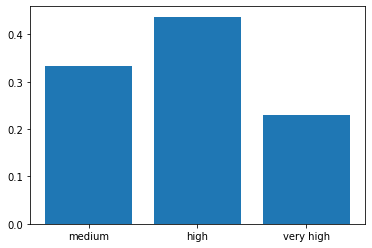

In [42]:
plt.bar(["medium","high","very high"], avgs_2)

## Classification

In [46]:
def printNice(clf, X_test, y_test, X_train, y_train):
    print("TEST SET: ")
    print(classification_report(y_test, clf.predict(X_test)))
    print("\n\n\nTRAIN SET: ")
    print(classification_report(y_train, clf.predict(X_train)))

### Decision Tree

In [43]:
acc_train = []
acc_test = []
classifiers = []
for a in np.linspace(0.001, 0.1, 100):
    clf_dec = DecisionTreeClassifier(random_state=0, ccp_alpha=a)
    clf_dec.fit(X_train, y_train)
    classifiers.append(clf_dec)
    acc_train.append(accuracy_score(y_train, clf_dec.predict(X_train)))
    acc_test.append(accuracy_score(y_test, clf_dec.predict(X_test)))

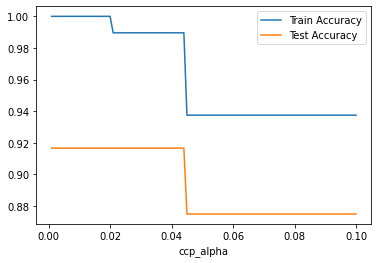

In [44]:
plt.plot(np.linspace(0.001, 0.1, 100),acc_train, label="Train Accuracy")
plt.plot(np.linspace(0.001, 0.1, 100),acc_test, label="Test Accuracy")
plt.xlabel("ccp_alpha")
plt.legend()

In [47]:
printNice(classifiers[0], X_test, y_test, X_train, y_train)

TEST SET: 
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        16
           1       0.91      1.00      0.95        21
           2       0.85      1.00      0.92        11

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.91        48
weighted avg       0.93      0.92      0.91        48




TRAIN SET: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00        21

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



[Text(2790.0, 4892.4, 'sanitation_access <= 0.835\ngini = 0.638\nsamples = 96\nvalue = [31, 44, 21]\nclass = high'),
 Text(1860.0, 3805.2, 'sanitation_access <= -0.264\ngini = 0.485\nsamples = 75\nvalue = [31, 44, 0]\nclass = high'),
 Text(930.0, 2718.0, 'gini = 0.0\nsamples = 25\nvalue = [25, 0, 0]\nclass = medium'),
 Text(2790.0, 2718.0, 'p_growth_urban <= 0.772\ngini = 0.211\nsamples = 50\nvalue = [6, 44, 0]\nclass = high'),
 Text(1860.0, 1630.7999999999997, 'gini = 0.048\nsamples = 41\nvalue = [1, 40, 0]\nclass = high'),
 Text(3720.0, 1630.7999999999997, 'unemployment_rate <= 0.035\ngini = 0.494\nsamples = 9\nvalue = [5, 4, 0]\nclass = medium'),
 Text(2790.0, 543.5999999999995, 'gini = 0.0\nsamples = 5\nvalue = [5, 0, 0]\nclass = medium'),
 Text(4650.0, 543.5999999999995, 'gini = 0.0\nsamples = 4\nvalue = [0, 4, 0]\nclass = high'),
 Text(3720.0, 3805.2, 'gini = 0.0\nsamples = 21\nvalue = [0, 0, 21]\nclass = very high')]

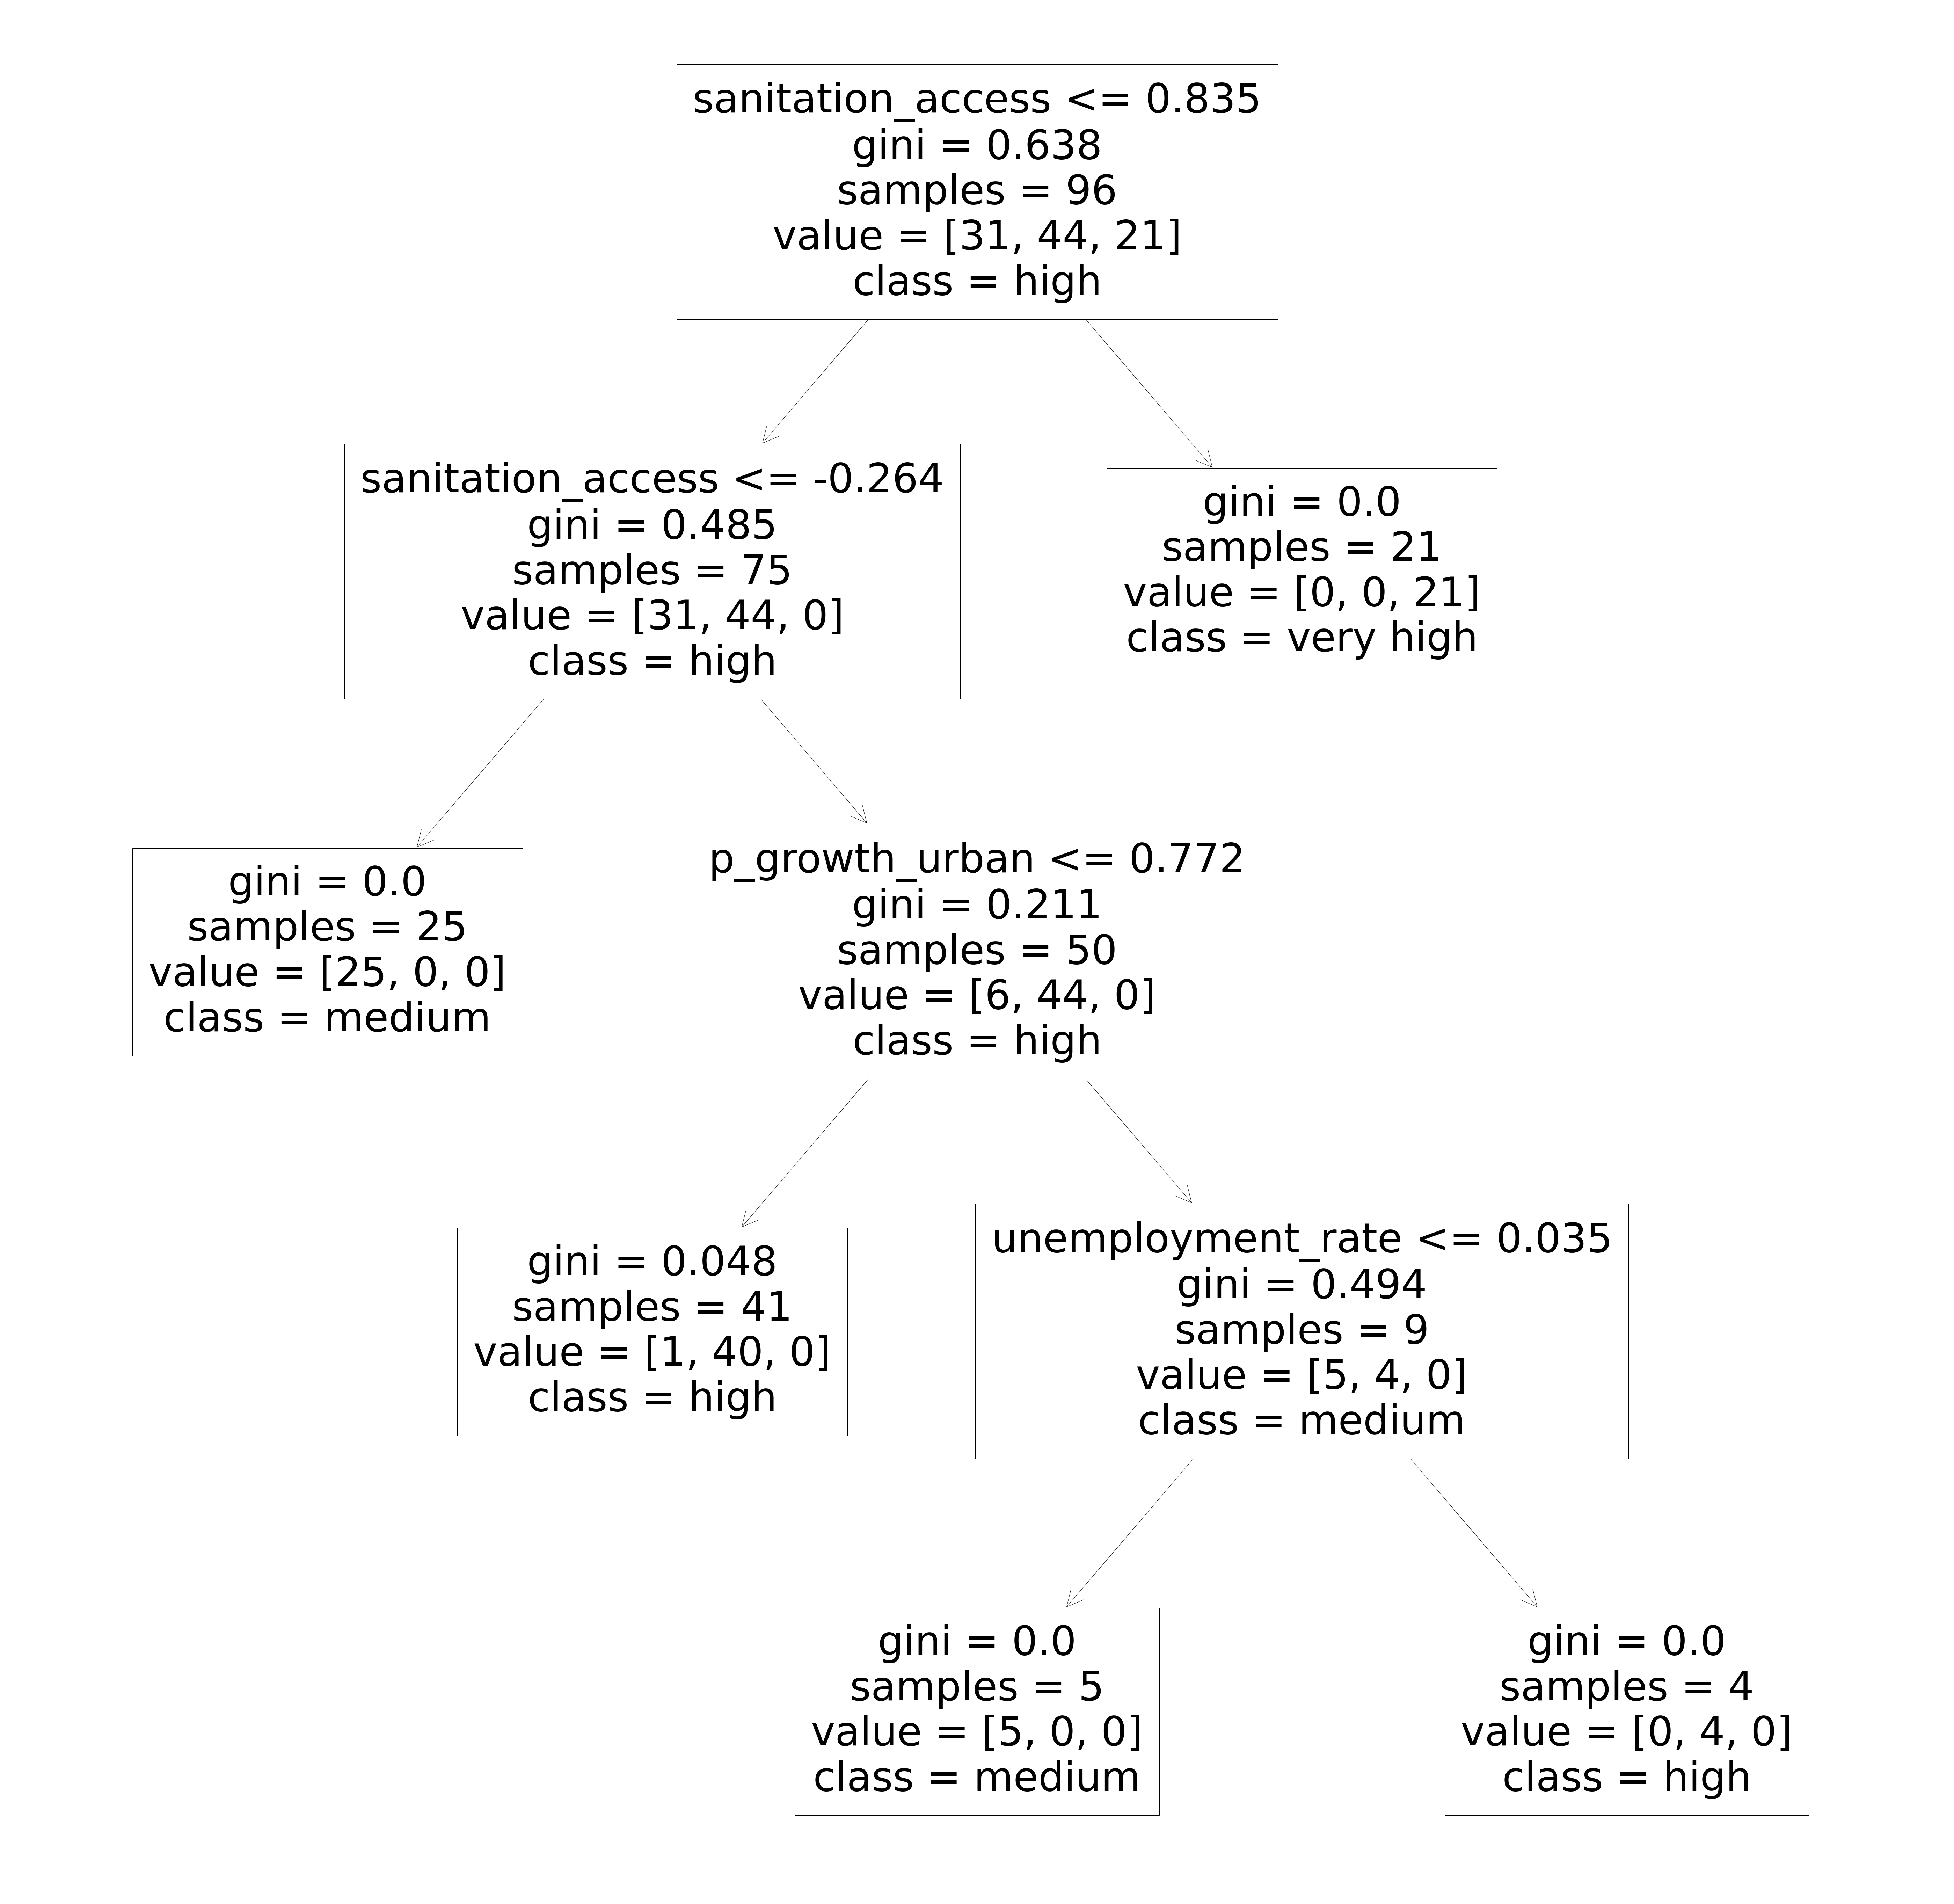

In [51]:
fig = plt.figure(figsize=(100,100))
ax = fig.add_subplot(111)
tree.plot_tree(classifiers[32],ax=ax, feature_names=X_unnormalized.columns[selector.support_], class_names=["medium", "high", "very high"])

### Random Forest

In [85]:
acc_train = []
acc_test = []
clf_forests = []
for d in range(2,10):
    clf_forest = RandomForestClassifier(max_depth=d, random_state=420)
    clf_forest.fit(X_train, y_train)
    acc_train.append(accuracy_score(y_train, clf_forest.predict(X_train)))
    acc_test.append(accuracy_score(y_test, clf_forest.predict(X_test)))
    clf_forests.append(clf_forest)

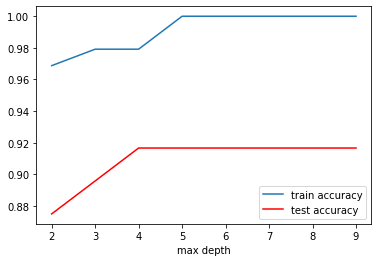

In [86]:
plt.plot(range(2,10),acc_train, label="train accuracy")
plt.plot(range(2,10), acc_test, c="red", label="test accuracy")
plt.xlabel("max depth")
plt.legend()

In [89]:
printNice(clf_forests[2], X_test, y_test, X_train, y_train)

TEST SET: 
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        16
           1       0.91      1.00      0.95        21
           2       0.85      1.00      0.92        11

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.91        48
weighted avg       0.93      0.92      0.91        48




TRAIN SET: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        31
           1       0.96      1.00      0.98        44
           2       1.00      1.00      1.00        21

    accuracy                           0.98        96
   macro avg       0.99      0.98      0.98        96
weighted avg       0.98      0.98      0.98        96



### Gradient Boosting

In [92]:
acc_train = []
acc_test = []
gbcs = []
for a in np.linspace(0.001, 0.1, 100):
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0, ccp_alpha=a)
    gbc.fit(X_train, y_train)
    acc_train.append(accuracy_score(y_train, gbc.predict(X_train)))
    acc_test.append(accuracy_score(y_test, gbc.predict(X_test)))
    gbcs.append(gbc)

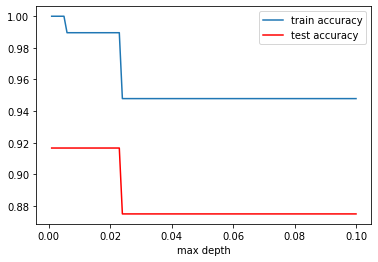

In [97]:
plt.plot(np.linspace(0.001, 0.1, 100),acc_train, label="train accuracy")
plt.plot(np.linspace(0.001, 0.1, 100), acc_test, c="red", label="test accuracy")
plt.xlabel("max depth")
plt.legend()

In [98]:
printNice(gbcs[0], X_test, y_test, X_train, y_train)

TEST SET: 
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        16
           1       0.91      1.00      0.95        21
           2       0.85      1.00      0.92        11

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.91        48
weighted avg       0.93      0.92      0.91        48




TRAIN SET: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00        21

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



### Comparison

In [110]:
X_anthony = X_unnormalized[["gni", "life_satis", "life_expectancy", "p_growth_urban", "unemployment_rate"]]
std_scaler = StandardScaler()
X_a = std_scaler.fit_transform(X_anthony)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, np.asarray(Y), test_size=0.33, random_state=42, stratify=Y)
acc_train = []
acc_test = []
classifiers = []
for a in np.linspace(0.001, 0.1, 100):
    clf_dec = DecisionTreeClassifier(random_state=0, ccp_alpha=a)
    clf_dec.fit(X_train_a, y_train_a)
    classifiers.append(clf_dec)
    acc_train.append(accuracy_score(y_train_a, clf_dec.predict(X_train_a)))
    acc_test.append(accuracy_score(y_test_a, clf_dec.predict(X_test_a)))

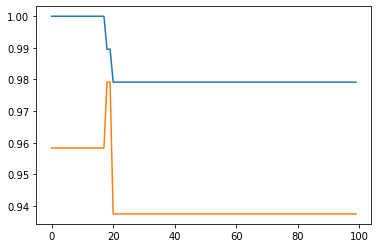

In [106]:
plt.plot(acc_train)
plt.plot(acc_test)

In [115]:
printNice(classifiers[19], X_test_a, y_test_a, X_train_a, y_train_a)

TEST SET: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.95      1.00      0.98        21
           2       1.00      1.00      1.00        11

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48




TRAIN SET: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.98      1.00      0.99        44
           2       1.00      1.00      1.00        21

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96



In [118]:
acc_train = []
acc_test = []
clf_forests = []
for d in range(2,10):
    clf_forest = RandomForestClassifier(max_depth=d, random_state=420)
    clf_forest.fit(X_train_a, y_train_a)
    acc_train.append(accuracy_score(y_train_a, clf_forest.predict(X_train_a)))
    acc_test.append(accuracy_score(y_test_a, clf_forest.predict(X_test_a)))
    clf_forests.append(clf_forest)

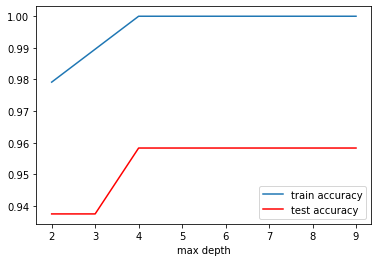

In [119]:
plt.plot(range(2,10),acc_train, label="train accuracy")
plt.plot(range(2,10), acc_test, c="red", label="test accuracy")
plt.xlabel("max depth")
plt.legend()

In [122]:
printNice(clf_forests[2], X_test_a, y_test_a, X_train_a, y_train_a)

TEST SET: 
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.91      1.00      0.95        21
           2       1.00      1.00      1.00        11

    accuracy                           0.96        48
   macro avg       0.97      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48




TRAIN SET: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00        21

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [123]:
acc_train = []
acc_test = []
gbcs = []
for a in np.linspace(0.001, 0.1, 100):
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0, ccp_alpha=a)
    gbc.fit(X_train_a, y_train_a)
    acc_train.append(accuracy_score(y_train_a, gbc.predict(X_train_a)))
    acc_test.append(accuracy_score(y_test_a, gbc.predict(X_test_a)))
    gbcs.append(gbc)

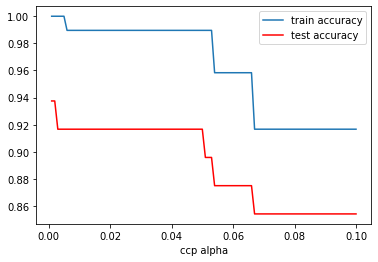

In [124]:
plt.plot(np.linspace(0.001, 0.1, 100),acc_train, label="train accuracy")
plt.plot(np.linspace(0.001, 0.1, 100), acc_test, c="red", label="test accuracy")
plt.xlabel("ccp alpha")
plt.legend()

In [125]:
printNice(gbcs[0], X_test_a, y_test_a, X_train_a, y_train_a)

TEST SET: 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.91      0.95      0.93        21
           2       1.00      1.00      1.00        11

    accuracy                           0.94        48
   macro avg       0.95      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48




TRAIN SET: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00        21

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



# One Class SVM

In [126]:
from sklearn.svm import OneClassSVM

In [147]:
osvm = OneClassSVM(gamma="auto", nu=0.1).fit(X)

In [151]:
outlier_rows = df[osvm.predict(X) == -1]

(array([8., 0., 0., 0., 2., 1., 1., 1., 2., 3.]),
 array([2005. , 2006.5, 2008. , 2009.5, 2011. , 2012.5, 2014. , 2015.5,
        2017. , 2018.5, 2020. ]),
 <BarContainer object of 10 artists>)

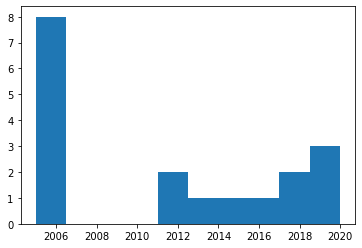

In [154]:
plt.hist(outlier_rows.year)

In [179]:
fig, axes = plt.subplots(20,2, figsize=(100,500))
for i, column in enumerate(X_unnormalized.columns):
    axes[i][0].hist(df[column])
    axes[i][0].set_title(column)
    axes[i][1].hist(outlier_rows[column])
    axes[i][1].set_title(column)

Text(0.5, 1.0, 'Hep-B Immunization Histogram (Outlier Data)')

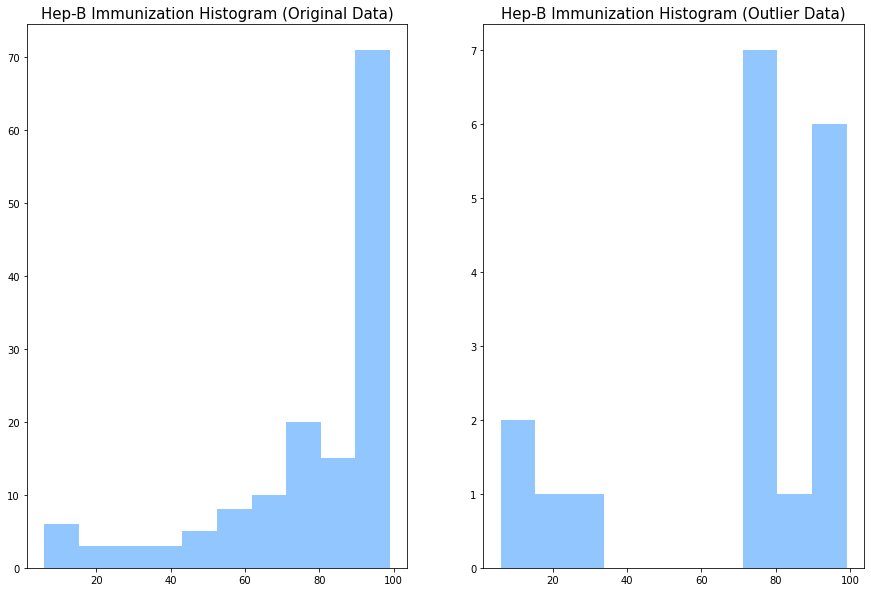

In [190]:
plt.style.use("seaborn-pastel")

fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].hist(df.immunization_hepb)
axes[0].set_title("Hep-B Immunization Histogram (Original Data)", fontsize=15)
axes[1].hist(outlier_rows.immunization_hepb)
axes[1].set_title("Hep-B Immunization Histogram (Outlier Data)", fontsize=15)

Text(0.5, 1.0, 'Drinking Water Histogram (Outlier Data)')

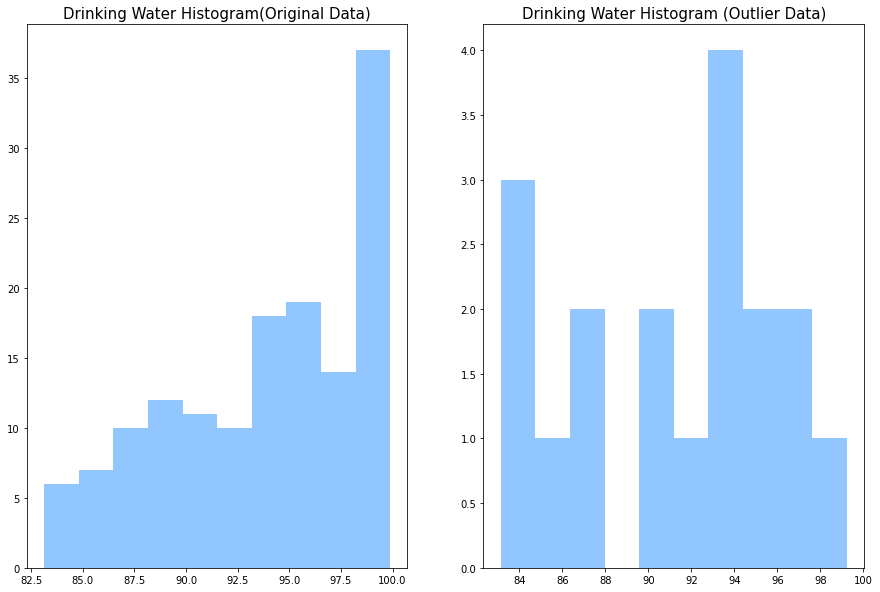

In [191]:
fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].hist(df.drinking_water_access)
axes[0].set_title("Drinking Water Histogram(Original Data)", fontsize=15)
axes[1].hist(outlier_rows.drinking_water_access)
axes[1].set_title("Drinking Water Histogram (Outlier Data)", fontsize=15)

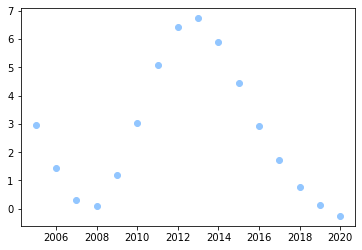

In [199]:
plt.scatter(df[df.name == "Lebanon"].year, df[df.name == "Lebanon"].p_growth_urban)

(array([ 6.,  7., 10., 12., 11., 10., 18., 19., 14., 37.]),
 array([83.13360985, 84.80860153, 86.48359322, 88.1585849 , 89.83357658,
        91.50856827, 93.18355995, 94.85855163, 96.53354331, 98.208535  ,
        99.88352668]),
 <BarContainer object of 10 artists>)

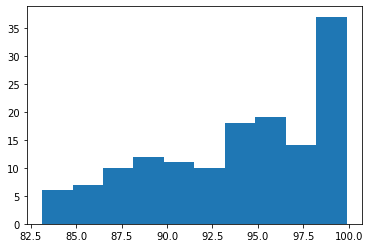

In [169]:
plt.hist(df.drinking_water_access)